In [1]:
import tensorflow as tf
import numpy as np
import glob
import os
import pandas as pd
tf.compat.v1.reset_default_graph()
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Softmax, Bidirectional, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import confusion_matrix 
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import warnings
import seaborn as snb
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [11]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

le = LabelEncoder()
le.fit(train_df['ActivityName'])

train_df['ActivityName'] = le.transform(train_df['ActivityName'])
test_df['ActivityName'] = le.transform(test_df['ActivityName'])

train_df = train_df.drop(columns = ['subject', 'Activity']).rename(columns = {'ActivityName':'AN'})
test_df = test_df.drop(columns = ['subject', 'Activity']).rename(columns = {'ActivityName':'AN'})

In [12]:
(train, train_labels) = (train_df.values[:, :-1], train_df.values[:, -1])
(test, test_labels) = (test_df.values[:, :-1], test_df.values[:, -1])
binary_train_labels = np.zeros(train_labels.shape)
binary_train_labels = np.where(train_labels>2, binary_train_labels, binary_train_labels+1)

binary_test_labels = np.zeros(test_labels.shape)
binary_test_labels = np.where(test_labels>2, binary_test_labels, binary_test_labels+1)


In [13]:
_train = train_df[(train_df['AN'] == 3 ) | ( train_df['AN'] == 4) | (train_df['AN'] == 5)]
_test = test_df[(test_df['AN'] == 3 ) | ( test_df['AN'] == 4) | (test_df['AN'] == 5)]
(train_1, train_labels_1) = (_train.values[:, :-1], _train.values[:, -1])
(test_1, test_labels_1) = (_test.values[:, :-1], _test.values[:, -1])
train_1 = train_1.reshape((train_1.shape[0],  train_1.shape[1], 1))
test_1 = test_1.reshape((test_1.shape[0],  test_1.shape[1], 1))
train_labels_1 = to_categorical(train_labels_1)[:, 3:]
test_labels_1 = to_categorical(test_labels_1)[:, 3:]

##################################################################################################################

_train = train_df[(train_df['AN'] == 0 ) | ( train_df['AN'] == 1) | (train_df['AN'] == 2)]
_test = test_df[(test_df['AN'] == 0 ) | ( test_df['AN'] == 1) | (test_df['AN'] == 2)]
(train_2, train_labels_2) = (_train.values[:, :-1], _train.values[:, -1])
(test_2, test_labels_2) = (_test.values[:, :-1], _test.values[:, -1])
train_2 = train_2.reshape((train_2.shape[0],  train_2.shape[1], 1))
test_2 = test_2.reshape((test_2.shape[0],  test_2.shape[1], 1))
train_labels_2 = to_categorical(train_labels_2)[:, :3]
test_labels_2 = to_categorical(test_labels_2)[:, :3]


In [15]:
#Refer 
#https://pdfs.semanticscholar.org/ddce/5ec101cfa6e86f033fccd979fdf16eea295c.pdf?_
#ga=2.126002187.700161425.1574244098-690025771.1573697931

def conv_1(batch_size = 32):
    optimizer = tf.keras.optimizers.Adam()
    conv_1d = Conv1D(filters = 100,input_shape = (561, 1) ,kernel_size = 3, strides = 1, padding = 'valid', 
                   activation = 'relu', kernel_initializer = 'glorot_normal')
    pool = MaxPooling1D(pool_size = 3, strides = 3)
    model = Sequential()
    model.add(conv_1d)
    model.add(pool)
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(units = 3, input_shape = (None, 3)))
    model.add(Softmax())
    model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model
def conv_2(batch_size = 32):
    optimizer = tf.keras.optimizers.Adam()
    model = Sequential()
    model.add(Conv1D(filters = 30,input_shape = (561, 1) ,kernel_size = 3, strides = 1, padding = 'valid', 
                   activation = 'relu', kernel_initializer = 'glorot_normal'))
    model.add(Conv1D(filters = 50,kernel_size = 3, strides = 1, padding = 'valid', 
                   activation = 'relu', kernel_initializer = 'glorot_normal'))
    model.add(Conv1D(filters = 100,kernel_size = 3, strides = 1, padding = 'valid', 
                     activation = 'relu', kernel_initializer = 'glorot_normal'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(units = 3, input_shape = (None, 3)))
    model.add(Softmax())
    model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model

In [18]:
model_1 = conv_1()
model_1.fit(train_1, train_labels_1, batch_size = 32, epochs = 50, verbose = 0)

In [19]:
model_2 = conv_2()
model_2.fit(train_2, train_labels_2, batch_size = 32, epochs = 50, verbose = 0)

In [20]:
clf = DecisionTreeClassifier()
clf.fit(train, binary_train_labels)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [21]:
binary_predictions = clf.predict(test)
indexes = np.where(binary_predictions == 0, True, False)
dynamic_test_data = test[indexes][:,:,np.newaxis]
static_test_data = test[~indexes][:,:,np.newaxis]

In [22]:
p1 = model_1.predict(dynamic_test_data)
p2 = model_2.predict(static_test_data)

In [23]:
labels = np.zeros(binary_predictions.shape)
labels[indexes] = p1.argmax(axis = 1) + 3
labels[~indexes] = p2.argmax(axis = 1)

In [24]:
print(accuracy_score(test_labels, labels))
c_matrix = confusion_matrix(test_labels, labels)

0.9524940617577197


In [25]:
precision = c_matrix/c_matrix.sum(axis = 1).reshape((1, -1))
recall = c_matrix/c_matrix.sum(axis = 0).reshape((-1, 1))

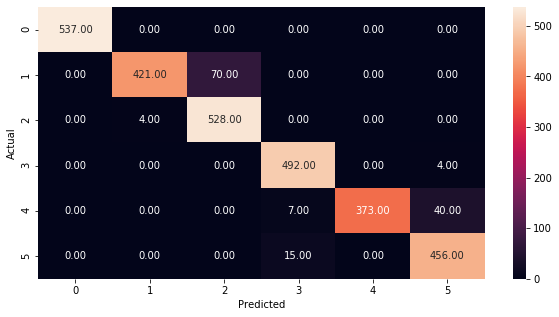

In [26]:
plt.figure(figsize = (10, 5))
snb.heatmap(c_matrix, annot = True, fmt = '.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [27]:
strings = ['Precision', 'Recall']
array = [precision, recall]

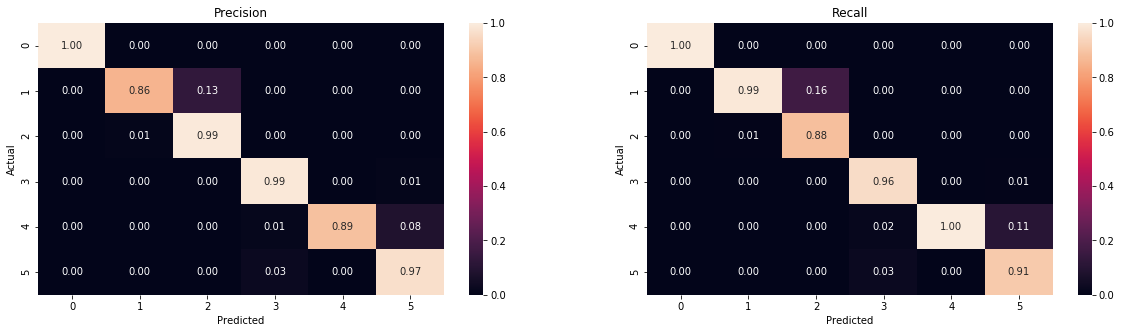

In [28]:
plt.figure(figsize = (20, 5))
for i in range(2):
    plt.subplot(1, 2, i+1)
    snb.heatmap(array[i], annot = True, fmt = '.2f')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(strings[i])
plt.show()
